# Distribuições Territoriais

Esta seção constrói mapas básicos das áreas de estudo: as cidades de Belo Horizonte, Rio de Janeiro e São Paulo. Especificamente, serão consolidadas e apresentadas as distribuições territoriais de variáveis demográficas e socioeconômicas de interesse. Adicionalmente, há o complemento de atributos territoriais que entende-se que são, também, variáveis explicativas. Especificamente, o foco estará, preliminarmente, nas seguintes variáveis, as quais serão elaboradas em maior profundidade mais à frente.

- Contagens populacionais
- Rendimentos médios
- Contagens de postos de trabalho
- Índice de bem estar urbano
- Medidas geométricas e topológicas da malha de vias caminháveis

Os itens que seguem tratam de detalhar os passos metodológicos utilizados, o embasamento teórico-conceitual (ou empírico) que é subjacente a esses passos, bem como as fontes de dados. Ainda, logo de início estão listadas as bibliotecas em Python que dão suporte a todo o processo. Maiores detalhes a respeito do funcionamento dessas bibliotecas são dados na medida do necessário. 

Os dados consolidados serão apresentados em formato de mapas (estáticos) e salvos para uso nas etapas posteriores do artigo. Análises espaciais e estat;isticas mais aprofundadas serão conteúdo de scripts mais à frente. De particular interesse será verificar a articulação entre as porções do território de cada cidade, uma vez que esses fluxos sejam confrontados com os fluxos e as infraestruturas de transporte motorizado.

# Procedimentos Preliminares

## Bibliotecas

In [1]:
import os
import pathlib
import re
import requests
from string import ascii_uppercase

import basedosdados as bd
import geobr
import geopandas as gpd
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from getpass import getpass
from shapely.geometry import Point, LineString, box
from tobler.area_weighted import area_interpolate
from tobler.util import h3fy

## Parâmetros de Base

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('Solarize_Light2')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
gcloud_id = getpass('Google Cloud Services billing ID:')

Google Cloud Services billing ID: ········


In [5]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3106200 -> Belo Horizonte
ibge_id = [3303302, 3304904, 3301900] # -> Niteroi e Sao Goncalo e Itaboraí

# Das Malhas Territorias

A malha hexagonal H3 será utilizada como recorte espacial principal ao longo das análises†. Recortes hexagonais apresentam vantagens importantes frente a outras geometrias, sobretudo, eles podem reduzir vieses amostrais derivados de efeitos de borda e, adicionalmente, são mais mais adequados do que malhas retangulares para analisar fenômenos em que relações de vizinhança e conectividade são importantes (Birch, Oom, & Beecham, 2007). Essas vantagens da malha hexagonal serão mais imporantes quando estiverem sendo executadas as análises de acessibilidade, mas, até lá, também foi mostrado por Birch et al. (2007) que hexágonos favorecem a visualização de padrões e mitigam, em alguma medida, efeitos de borda.

Esses efeitos de borda, simplificadamente, dizem respeito a erros de representação na variação local dos dados. Isto é, outras geometrias — malhas quadriculadas, p. ex. — são mais propensas a apresentar variações bruscas e artificiais entre vizinhos — uma quadrícula com valores muito altos ladeada por quadrículas com valores muito baixos. Isso prejudica a análise e a visualização, assim favorecendo erros de interpretação.

Dados socioeconômicos e demográficos, por sua vez, serão imputados em cada hexágono a partir do enso demográfico de 2010. Esses dados censitários serão requisitados ao datalake público da Base dos Dados‡, enquanto que as malhas desses setores serão obtidas junto à biblioteca geobr⨥. Assim, de posse das malhas do IBGE e dos respectivos dados, procedimentos de interpolação espacial⁙ farão a transferência dos dados do censo para os hexágonos.

Complementarmente, para além das informações dos setores censitários, a grade estatística⁜ também será utilizada como insumo, a qual apresenta contagens populacionais com uma resolução maior que a dos agregados por setor: há uma malha com resolução de 200x200 m em áreas urbanas e de 1x1 km em áreas rurais. A grade é importante porque remove as áreas inabitadas — a Floresta d Tijuca, no Rio de Janeiro, p. ex. — e porque permitem localizar o centroide dos hexágonos de maneira mais precisa: seguindo recomendação de Stępniak and Jacobs-Crisioni (2017), o centro de cada geometria deve ser ponderado pela distribuição populacional nela contida, a fim de que haja uma representação mais precisa dos tempos de viagem entre geometrias.

Resta definir qual a resolução dessas malha. Conforme demonstrado, por exemplo, em Pereira et al. (2019), é importante avaliar distintos tamanhos de geometria, a fim de verificar se os resultados obtidos são realmente robustos ou se não passam de artefatos computacionais. Mas, quais resoluções⁕? A menor escala na qual ainda há dados disponíveis é a grade estatística, de maneira que hexágonos menores que ela não agregariam nenhum valor à análise, ao mesmo tempo em que elevariam, desnecessariamente, o tempo de processamento computacional. Com efeito, a menor resolução utilizada é a 9, com área relativamente próxima a um quadrado de lado 200m. No outro extremo, resta definir a maior resolução utilizada. A maior delas será a 7, com área de aproximadamente 5 km2. Tamahos maiores agregariam grandes regiões muito distintas entre si, contribuindo em demasiado para uma ilusão de homogeneidade a qual não existe — p. ex., a resolução 6 já conta com área de cercade 35km2. Portanto, serão avaliadas as resoluções 7, 8 e 9.

    Birch, C. P., Oom, S. P., & Beecham, J. A. (2007). Rectangular and hexagonal grids used for observation, experiment and simulation in ecology. Ecological modelling, 206(3-4), 347-359.
    
    Pereira, R. H., Banister, D., Schwanen, T., & Wessel, N. (2019). Distributional effects of transport policies on inequalities in access to opportunities in Rio de Janeiro. Journal of Transport and Land Use, 12(1), 741-764.
    
    Stępniak, M., & Jacobs-Crisioni, C. (2017). Reducing the uncertainty induced by spatial aggregation in accessibility and spatial interaction applications. Journal of Transport Geography, 61, 17-29.

    † Especificamente, será feito uso das bibliotecas em Python implementadas pela Uber (https://h3geo.org/), baseadas no sistema proposto em:

        Sahr, K., White, D., & Kimerling, A. J. (2003). Geodesic discrete global grid systems. Cartography and Geographic Information Science, 30(2), 121-134.
        
    ‡ ver https://basedosdados.org/

    ⨥ ver https://github.com/ipeaGIT/geobr
    
    ⁙ https://github.com/pysal/tobler

    ⁜ obtida diretamente do site do IBGE em https://censo2010.ibge.gov.br/component/saladeimprensa/?busca=1&id=3&idnoticia=3123&t=grade-estatistica-permite-obter-dados-censo-2010-diversos-recortes-espaciais&view=noticia
    
    ⁕ ver https://h3geo.org/docs/core-library/restable para uma lista de resoluções e as respectivas dimensões

## Malhas Censitárias

In [6]:
def get_study_area(ibge_id):
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    return pd.concat([
        geobr.read_census_tract(id_)
        for id_
        in ibge_id
        ])


tracts = get_study_area(ibge_id)

In [7]:
crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')
crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
tracts = tracts.to_crs(crs)

Abaixo, utiliza-se a função h3fy, cuja documentação pode ser encontrada [aqui](https://pysal.org/tobler/generated/tobler.util.h3fy.html).

In [9]:
hexes = h3fy(tracts, resolution=8)

# A Leitura dos Atributos Territoriais

In [10]:
# Query-building helper functions
def _sql_style_list(sequence):
    single_quoted_elements = [f"'{c}'" for c in sequence]
    return ', '.join(single_quoted_elements)


def query_selection_line(
        base_table: str,
        race_variable_map: dict[str, list[str]],
        user_vars: list[str] = None
        ) -> str:
    """Constructs a SELECT SQL query using race variable mapping and user-specified columns."""
    user_vars = user_vars or []
    
    # Flatten all race-specific variables into one set to avoid duplicates
    race_vars = sorted({v for vars_ in race_variable_map.values() for v in vars_})
    
    # Combine user-defined variables + race-related variables
    selected_columns = user_vars + race_vars
    
    columns_str = ", ".join(selected_columns)
    
    return f"SELECT {columns_str} FROM {base_table}"

In [11]:
# Census tables and vars to select
BASE_TABLE = "basedosdados.br_ibge_censo_2022.setor_censitario"

BASE_VARS = [
    'id_setor_censitario',
    'geometria',
    ]

RACE_VARIABLES_15PLUS = {
    "preta": [
        "V00658", "V00663", "V00668", "V00673", "V00678", "V00683", "V00688",
        "V00693", "V00698", "V00703", "V00708", "V00713", "V00718",
    ],
    "parda": [
        "V00660", "V00665", "V00670", "V00675", "V00680", "V00685", "V00690",
        "V00695", "V00700", "V00705", "V00710", "V00715", "V00720", 
    ],
    "branca": [
        "V00657", "V00662", "V00667", "V00672", "V00677", "V00682", "V00687",
        "V00692", "V00697", "V00702", "V00707", "V00712", "V00717",
    ],
    "amarela": [
        "V00659", "V00664", "V00669", "V00674", "V00679", "V00684", "V00689",
        "V00694", "V00699", "V00704", "V00709", "V00714", "V00719",
    ],
    "indígena": [
        "V00661", "V00666", "V00671", "V00676", "V00681", "V00686", "V00691",
        "V00696", "V00701", "V00706", "V00711", "V00716", "V00721",
    ],
}

In [12]:
def read_census_data(query, gcloud_id):
    data = bd.read_sql(query,
                       billing_project_id=gcloud_id)
    
    return (
        data.astype({'id_setor_censitario': np.int64})
            .astype({'id_setor_censitario': str})
            .rename(
                columns={
                    'v009': 'rendimento_medio',
                    'v002': 'habitantes',
                    'v001': 'domicilios',
                    }
                )
        )

In [13]:
# Requesting data
query = (
    query_selection_line(BASE_TABLE, RACE_VARIABLES_15PLUS, BASE_VARS)
    + " "
    f"WHERE id_municipio IN ({_sql_style_list(ibge_id)})"
    )

tract_data = read_census_data(query, gcloud_id)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [19]:
tract_data.head(3)

,id_setor_censitario,geometria,V00657,V00658,V00659,V00660,V00661,V00662,V00663,V00664,...,V00712,V00713,V00714,V00715,V00716,V00717,V00718,V00719,V00720,V00721
0,330190005000197,"POLYGON((-42.8323576 -22.7737084999999, -42.83...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,330330205001065,"POLYGON((-43.0206597 -22.9176523999999, -43.02...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,330330205000544,"POLYGON((-43.0810504 -22.8759858999999, -43.08...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [20]:
def collapse_race_groups(
        df: pd.DataFrame,
        race_var_map: dict[str, list[str]]
        ) -> pd.DataFrame:
    """
    For each race in the map, sums the respective columns and replaces them
    with a single column for that race.
    
    Returns a new DataFrame with race totals and all other non-race columns preserved.
    """
    df = df.copy()
    for race, vars_ in race_var_map.items():
        df[race] = df[vars_].sum(axis=1)
        df.drop(columns=vars_, inplace=True, errors='ignore')  # Drop original variables
    return df


tract_data = collapse_race_groups(tract_data, RACE_VARIABLES_15PLUS)

In [21]:
tract_data.head(3)

,id_setor_censitario,geometria,preta,parda,branca,amarela,indígena
0,330190005000197,"POLYGON((-42.8323576 -22.7737084999999, -42.83...",0,0,0,0,0
1,330330205001065,"POLYGON((-43.0206597 -22.9176523999999, -43.02...",0,0,0,0,0
2,330330205000544,"POLYGON((-43.0810504 -22.8759858999999, -43.08...",0,0,0,0,0


## Imputacao: Dados Censitários -> H3

In [30]:
tract_data = gpd.GeoDataFrame(
    tract_data,
    crs=4674,
    geometry=gpd.GeoSeries.from_wkt(
        tract_data.geometria
        )
    ).drop(columns='geometria')

## Interpolações: Setor Censitário → Hexágonos

In [36]:
hex_with_data = (
    area_interpolate(
        source_df=tract_data.to_crs(31983).assign(
            geometry=lambda x: x.buffer(0)
            ),
        target_df=hexes,
        extensive_variables=['preta', 'parda', 'amarela', 'indígena', 'branca'],
        )
    .drop(columns='geometry')
    .set_index(hexes.index)
    .pipe(
        lambda df: pd.merge(
            hexes,
            df,
            left_index=True,
            right_index=True,
            )
        )
    )

In [37]:
hex_with_data.head(2)

,geometry,preta,parda,amarela,indígena,branca
hex_id,,,,,,
88a8a2a40dfffff,"POLYGON ((705928.729 7479681.266, 705496.131 7...",144.82,300.70,0.00,0.00,162.31
88a8a2a5d9fffff,"POLYGON ((705666.261 7484168.576, 705146.654 7...",0.44,1.94,0.00,0.00,0.14


A visualização do mapa abaixo é feita com o método GeoDataFrame.explore do GeoPandas. Você pode [consultar a documentação](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) para entender melhor como o método funciona.

In [48]:
from segregation.singlegroup import Dissim, Gini
from segregation.dynamics import compute_multiscalar_profile

In [50]:
db = hex_with_data.assign(
    total=hex_with_data.drop(columns='geometry').sum(axis='columns'),
    preta_parda=hex_with_data.preta + hex_with_data.parda
    )

In [69]:
def compute_racial_polarity(df: pd.DataFrame) -> pd.Series:
    others = df[['preta', 'parda', 'amarela', 'indígena']].sum(axis=1)
    total = df['branca'] + others
    return ((others - df['branca']) / total.replace(0, pd.NA)).fillna(0)

db['racial_polarity'] = compute_racial_polarity(db)

In [73]:
db.explore(column='racial_polarity', cmap='PiYG', tiles='Carto DB positron')

In [62]:
sac_gini_profile = compute_multiscalar_profile(
    db,
    segregation_index=Dissim,
    group_pop_var="parda",
    total_pop_var="total",
    distances= range(500, 5500, 500),
    )

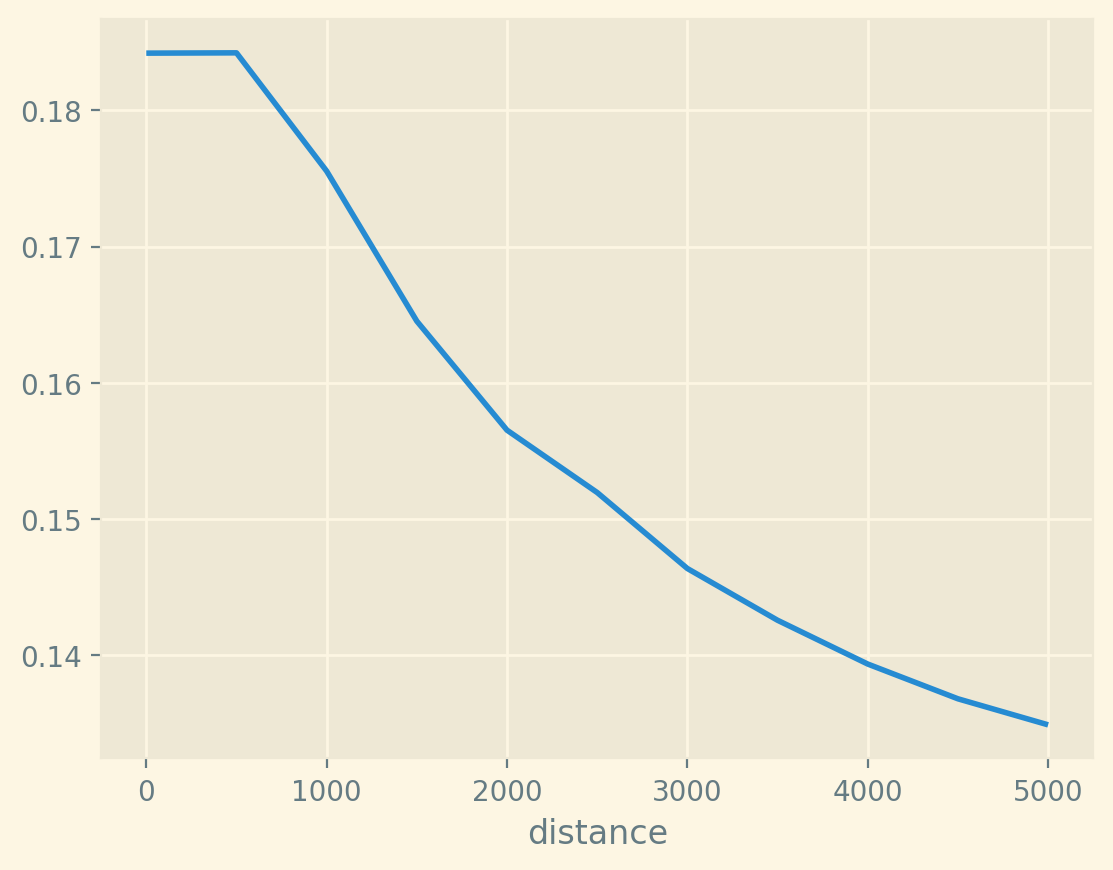

In [63]:
sac_gini_profile.plot()
plt.show()

In [68]:
db.columns

Index(['geometry', 'preta', 'parda', 'amarela', 'indígena', 'branca', 'total',
       'preta_parda'],
      dtype='object')